<a href="https://colab.research.google.com/github/steliosg23/Data_Challenge_2025/blob/main/Dataset_Augmentation_Product_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Libraries





### Import Libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import networkx as nx

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


### Set Paths and Load Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the base directory (adjust this path to your directory)
base_dir = '/content/drive/MyDrive/Data Science AUEB/Data Challenge/data/'

# Define file paths
edgelist_path = f'{base_dir}edgelist.txt'
descriptions_path = f'{base_dir}description.txt'
prices_path = f'{base_dir}price.txt'
y_train_path = f'{base_dir}y_train.txt'
test_path = f'{base_dir}test.txt'

# Load dataset files
edgelist = pd.read_csv(edgelist_path, sep=',', header=None, names=['source', 'target'])




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Process Product Descriptions

In [ ]:
# Load descriptions file as plain text
with open(descriptions_path, 'r') as file:
    lines = file.readlines()

# Split each line by '|=|' and process the data
product_data = []
for line in lines:
    line = line.strip()  # Remove leading/trailing whitespace
    # Split by '|=|' (no spaces) and ensure there are exactly two parts (ID and content)
    parts = line.split('|=|')
    if len(parts) == 2:
        product_id, content = parts
        product_data.append([product_id, content])
    else:
        # Debugging: print lines that do not conform to the expected format
        print(f"Skipping invalid line: {line}")

# Create a DataFrame from the processed data
import pandas as pd
descriptions_df = pd.DataFrame(product_data, columns=['product_id', 'title_and_description'])

# Display the DataFrame
descriptions_df

,product_id,title_and_description
0,0,FSA Orbit 1.5ZS Zero Stack Internal Bicycle He...
1,1,Columbia Bugaboo II 12-Foot-by-9-Foot 4-Pole 5...
2,2,Men's New Gym Workout Short Gary Majdell Sport
3,3,Vktech Cute Creative Girls Tibet Silver Petal ...
4,4,Real Avid ZipWire Pistol Cleaning Kit Real Avi...
...,...,...
276448,276448,Abu Garcia 4601C3 Ambassadeur C3 Baitcast Roun...
276449,276449,1 Dozen Gold Tip Hunter Expedition Arrow Shaft...
276450,276450,Australian Outrider Air-Flow Trail Pad Black A...
276451,276451,S&amp;S Worldwide Award Ribbons (Pack of 36) F...


### Load Prices, Y Train, and Test Data

In [ ]:
# Load prices and other files
prices = pd.read_csv(prices_path, sep=',', header=None, names=['product_id', 'price'])
y_train = pd.read_csv(y_train_path, sep=',', header=None, names=['product_id', 'class_label'])
test_ids = pd.read_csv(test_path, header=None, names=['product_id'])


In [ ]:
# 3. Convert 'product_id' columns to string type to ensure consistency
descriptions_df['product_id'] = descriptions_df['product_id'].astype(str)
prices['product_id'] = prices['product_id'].astype(str)
y_train['product_id'] = y_train['product_id'].astype(str)

# 4. Merge the dataframes based on 'product_id' to get the respective details
train_df = y_train.merge(descriptions_df, on='product_id', how='left')
train_df = train_df.merge(prices, on='product_id', how='left')

# Display the first few rows of the merged DataFrame with only products in y_train
train_df


,product_id,class_label,title_and_description,price
0,66795,9,Pro-tec Classic Skate Independent Skateboard H...,NaN
1,242781,3,Callaway Golf RAZR Staff Cart Bag NEW CALLAWAY...,NaN
2,91280,2,Heckler and Koch Entourage Knife Combo with Ed...,NaN
3,56356,5,Reelight Sl120 Flashing Extended Bicycle Headl...,87.99
4,218494,0,Columbia Boys 8-20 Bug Shield Pant,NaN
...,...,...,...,...
182001,275200,0,"Mens Blood, Sweat and Tears Workout Tank by Pi...",NaN
182002,52191,2,1/4&quot; x 500 FT. Shock Cord - BLK Bungee co...,55.00
182003,149974,1,Spy Optic Clash Wrap Sunglasses,NaN
182004,9664,5,Token Bottom Bracket BB TK877TBT Ex Type Integ...,89.00


### Drop NaN Price Rows and Check for Missing Values

In [ ]:
# Check for missing values (NaN) in the final merged DataFrame
nan_counts = train_df.isnull().sum()

# Display the count of missing values in each column
print("Missing Values per Column:")
print(nan_counts)

# Optionally, display rows with missing values
missing_data = train_df[train_df.isnull().any(axis=1)]
print("\nRows with missing values:")
print(missing_data)

# Drop rows with missing 'price' values
train_df = train_df.dropna(subset=['price'])

# Verify that 'price' column no longer has missing values
nan_counts_after_drop = train_df.isnull().sum()
print("\nMissing Values per Column after dropping NaNs in 'price':")
print(nan_counts_after_drop)


Missing Values per Column:
product_id                   0
class_label                  0
title_and_description        0
price                    46384
dtype: int64

Rows with missing values:
       product_id  class_label  \
0           66795            9   
1          242781            3   
2           91280            2   
4          218494            0   
15         268517            5   
...           ...          ...   
181989     150900            2   
181995      39852           11   
181998     203691            6   
182001     275200            0   
182003     149974            1   

                                    title_and_description  price  
0       Pro-tec Classic Skate Independent Skateboard H...    NaN  
1       Callaway Golf RAZR Staff Cart Bag NEW CALLAWAY...    NaN  
2       Heckler and Koch Entourage Knife Combo with Ed...    NaN  
4                      Columbia Boys 8-20 Bug Shield Pant    NaN  
15               Shimano Deore M525A Front Disc Hub Black    NaN 

In [ ]:
train_df

,product_id,class_label,title_and_description,price
3,56356,5,Reelight Sl120 Flashing Extended Bicycle Headl...,87.99
5,169687,2,Troy SRAI-DLT-CXBT-00 Troy Delta-Cx - 12in - B...,217.07
6,226442,5,Nashbar Torque Wrench Take the agony and angui...,64.99
7,197572,1,Casio Men's Watch G7600-1V,85.00
8,126461,2,Five Pack of Alabama Style Umbrella 5 Arm 5 1/...,21.99
...,...,...,...,...
181999,68770,2,M14 M1A Tactical Combo With Mount + 4-16x50 Ri...,139.95
182000,218882,2,Mk-250 Compound Crossbow Brand New Powerful Bo...,170.00
182002,52191,2,1/4&quot; x 500 FT. Shock Cord - BLK Bungee co...,55.00
182004,9664,5,Token Bottom Bracket BB TK877TBT Ex Type Integ...,89.00


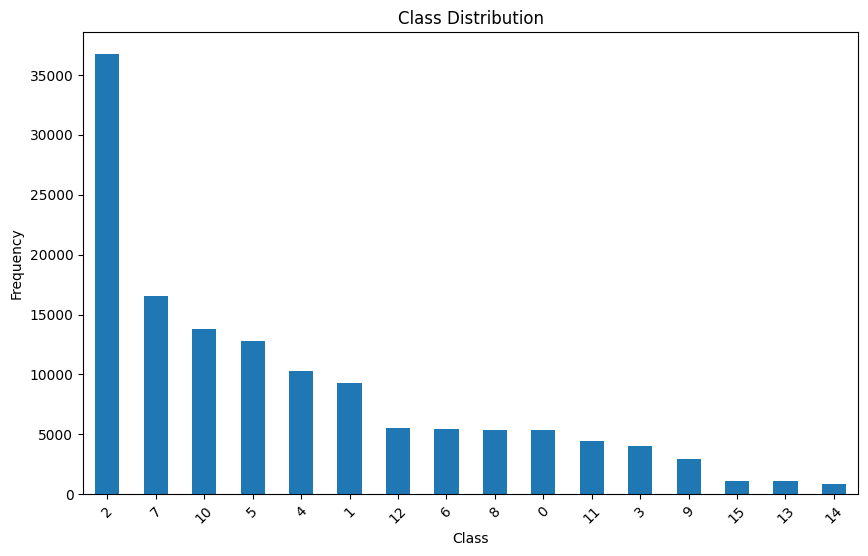

class_label
2     36729
7     16514
10    13835
5     12793
4     10311
1      9292
12     5558
6      5456
8      5365
0      5339
11     4462
3      4013
9      2935
15     1088
13     1078
14      854
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the 'class' column
plt.figure(figsize=(10,6))
train_df['class_label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
distribution = train_df['class_label'].value_counts()
print(distribution)


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords, lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess the text
def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove special characters, numbers, and non-ASCII characters
    text = re.sub(r'[^\x00-\x7F\s]', '', text)  # Remove non-ASCII characters
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers

    # Tokenization and stopword removal
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a string
    return ' '.join(words)

# Apply the cleaning function to the 'title_and_description' column
train_df['title_and_description'] = train_df['title_and_description'].apply(clean_text)
train_df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-27-6430d0dc20e1>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['title_and_description'] = train_df['title_and_description'].apply(clean_text)


,product_id,class_label,title_and_description,price
3,56356,5,reelight sl flashing extended bicycle headligh...,87.99
5,169687,2,troy sraidltcxbt troy deltacx black sraidltcxbt,217.07
6,226442,5,nashbar torque wrench take agony anguish tryin...,64.99
7,197572,1,casio men watch gv,85.00
8,126461,2,five pack alabama style umbrella arm quot rig ...,21.99
...,...,...,...,...
181999,68770,2,tactical combo mount x rifle scope w target tu...,139.95
182000,218882,2,mk compound crossbow brand new powerful bow ex...,170.00
182002,52191,2,quot x ft shock cord blk bungee cord construct...,55.00
182004,9664,5,token bottom bracket bb tktbt ex type integrat...,89.00


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Build the graph (assuming you have 'edgelist' already)
G = nx.Graph()
G.add_edges_from(edgelist.values)

# Print the number of nodes and edges before filtering
before_nodes = len(G.nodes)
before_edges = len(G.edges)
print(f"Before filtering:")
print(f"Number of nodes: {before_nodes}")
print(f"Number of edges: {before_edges}")

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Convert degree centrality to a numpy array for easier analysis
degree_values = np.array(list(degree_centrality.values()))

# Calculate percentiles for degree centrality
degree_25th = np.percentile(degree_values, 25)
degree_75th = np.percentile(degree_values, 75)

# Apply the threshold using percentiles:
degree_filtered_nodes = [node for node, dc in degree_centrality.items() if dc > degree_25th]

# Optionally, use z-scores to filter nodes based on degree centrality:
degree_zscore = zscore(degree_values)

# Define Z-score thresholds (e.g., nodes with Z-score < -1 or > 1 are considered extreme)
degree_zscore_filtered_nodes = [node for node, z in zip(degree_centrality.keys(), degree_zscore) if abs(z) < 1]

# Using only degree centrality filtering for the final set of nodes
important_nodes = degree_filtered_nodes

# Create a subgraph with the important nodes
G_preprocessed = G.subgraph(important_nodes).copy()

# Print the number of nodes and edges after filtering
after_nodes = len(important_nodes)
after_edges = G_preprocessed.number_of_edges()
print(f"After filtering:")
print(f"Number of nodes: {after_nodes}")
print(f"Number of edges: {after_edges}")


Before filtering:
Number of nodes: 276453
Number of edges: 1811087
After filtering:
Number of nodes: 202332
Number of edges: 1655182


In [ ]:
import networkx as nx
import pandas as pd

# Ensure correct data types for comparison
graph_nodes = set(map(str, G_preprocessed.nodes()))  # Ensure graph nodes are strings


# Make sure to strip nodes only if they are strings (if they are integers, no need to strip)
graph_nodes = set(str(node) if isinstance(node, str) else str(node) for node in G_preprocessed.nodes())

# Step 1: Filter train_df to only include rows where the product_id is in the graph
filtered_df = train_df[train_df['product_id'].isin(graph_nodes)]

# Check if filtering worked as expected (optional debugging step)
print(f"Filtered DataFrame shape: {filtered_df.shape}")
print(f"Filtered DataFrame head:\n{filtered_df.head()}")


filtered_df.to_csv(f'{base_dir}filtered_train_df.csv', index=False)


Filtered DataFrame shape: (105426, 4)
Filtered DataFrame head:
  product_id  class_label                              title_and_description  \
3      56356            5  reelight sl flashing extended bicycle headligh...   
5     169687            2    troy sraidltcxbt troy deltacx black sraidltcxbt   
6     226442            5  nashbar torque wrench take agony anguish tryin...   
7     197572            1                                 casio men watch gv   
8     126461            2  five pack alabama style umbrella arm quot rig ...   

    price  
3   87.99  
5  217.07  
6   64.99  
7   85.00  
8   21.99  


In [ ]:
filtered_df

,product_id,class_label,title_and_description,price
3,56356,5,reelight sl flashing extended bicycle headligh...,87.99
5,169687,2,troy sraidltcxbt troy deltacx black sraidltcxbt,217.07
6,226442,5,nashbar torque wrench take agony anguish tryin...,64.99
7,197572,1,casio men watch gv,85.00
8,126461,2,five pack alabama style umbrella arm quot rig ...,21.99
...,...,...,...,...
181993,212651,7,nfl ounce travel mug oz heavy dity travel tumb...,22.49
181996,206234,5,sunlite cloud suspension cruiser saddle cruise...,27.50
181997,87551,2,guide gear popup ground blind guide gear popup...,49.99
181999,68770,2,tactical combo mount x rifle scope w target tu...,139.95


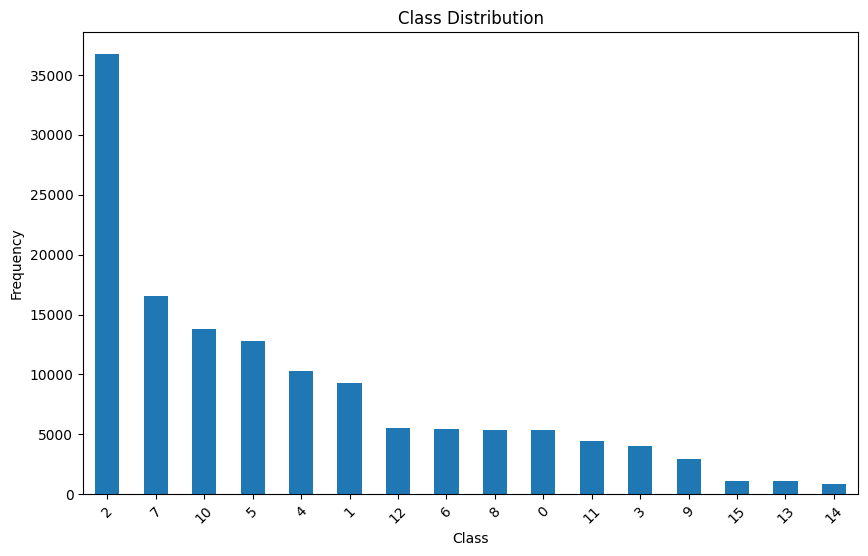

class_label
2     31359
10    11894
5     11075
4      8113
7      7910
1      7511
12     4859
6      4822
8      4446
0      3159
11     3084
3      2984
9      2498
14      676
13      548
15      488
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the 'class' column
plt.figure(figsize=(10,6))
train_df['class_label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
distribution = filtered_df['class_label'].value_counts()
print(distribution)


In [ ]:
import random
import pandas as pd
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, pipeline
import nltk
from nltk.corpus import wordnet
import re
from tqdm import tqdm  # Import tqdm
import logging
import torch
import os
import time
import warnings
warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('punkt_tab')

#train_df=train_df.sample(100)
# Enable synchronous CUDA error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Suppress transformers library logs
logging.getLogger('transformers').setLevel(logging.ERROR)

# Suppress NLTK download messages
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

# Define base directory and output file path
base_dir = '/content/drive/MyDrive/Data Science AUEB/Data Challenge/data/'
output_file = base_dir + 'augmented_train_df.csv'

# Check if CUDA (GPU) is available and set device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set up mBART model for back-translation
tokenizer = MBart50TokenizerFast.from_pretrained('facebook/mbart-large-50-many-to-many-mmt')
model = MBartForConditionalGeneration.from_pretrained('facebook/mbart-large-50-many-to-many-mmt').to(device)  # Move model to GPU if available

def back_translation(text, tokenizer, model, target_language='de_DE'):
    """Perform back-translation using mBART (English -> [target language] -> English)."""
    if not text.strip():
        return text  # Return the original text if it's empty or just whitespace

    max_length = 512
    tokens = tokenizer.encode(text, return_tensors="pt").to(device)  # Move the tokens to the same device as the model

    if tokens.shape[1] > max_length:
        tokens = tokens[:, :max_length]  # Truncate to max_length tokens

    # Perform translation from English -> [target language]
    # Specify the target language by passing the correct language code
    translated_to_target_language = model.generate(tokens, num_beams=5, max_length=512, early_stopping=True, forced_bos_token_id=tokenizer.lang_code_to_id[target_language])

    # Decode the translated text from target language
    translated_text = tokenizer.decode(translated_to_target_language[0], skip_special_tokens=True)

    # Now translate back to English from the target language
    # Use 'en_XX' for English in mBART
    back_to_english = model.generate(translated_to_target_language, num_beams=5, max_length=512, early_stopping=True, forced_bos_token_id=tokenizer.lang_code_to_id['en_XX'])

    # Decode back to English
    final_translated_text = tokenizer.decode(back_to_english[0], skip_special_tokens=True)

    return final_translated_text



def tokenize_text(text):
    """ Tokenize text only once to improve efficiency. """
    return nltk.word_tokenize(text)

def synonym_replacement(tokens):
    """ Replace a random word with a synonym, ensuring variability. """
    new_tokens = tokens.copy()
    random.shuffle(new_tokens)  # Shuffle words to introduce more variation
    for i, word in enumerate(new_tokens):
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Choose a random synonym to further increase variability
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_tokens[i] = synonym if synonym != word else word
    return ' '.join(new_tokens)

def random_insertion(tokens):
    """ Insert a random token into the text, ensure variability. """
    random_word = random.choice(tokens)
    random_position = random.randint(0, len(tokens))
    tokens.insert(random_position, random_word)
    return ' '.join(tokens)

def random_deletion(tokens):
    """ Randomly delete a token, ensuring variability. """
    if len(tokens) > 1:
        random_position = random.randint(0, len(tokens) - 1)
        del tokens[random_position]  # More randomness in deletion
    return ' '.join(tokens)

def sentence_shuffling(text):
    """ Shuffle words in sentences for more randomness. """
    try:
        sentences = re.split(r'(?<=[.!?]) +', text)  # Split based on punctuation marks
        shuffled_sentences = []
        for sentence in sentences:
            words = sentence.split()  # Split sentence into words
            random.shuffle(words)  # Shuffle words
            shuffled_sentences.append(' '.join(words))  # Rejoin shuffled words into the sentence
        return ' '.join(shuffled_sentences)  # Join shuffled sentences into a paragraph
    except Exception as e:
        print(f"Error in sentence shuffling: {e}")
        return text

def noise_injection(tokens):
    """ Add noise inside words by modifying characters randomly. """
    num_changes = random.randint(1, 3)  # Decide how many tokens to modify (between 1 and 3 tokens)

    for _ in range(num_changes):
        random_position = random.randint(0, len(tokens) - 1)  # Randomly choose a position
        word = tokens[random_position]

        # Randomly decide whether to add noise (random characters) or modify characters in the word
        if random.choice([True, False]):
            # Add random noise inside the word (e.g., insert random characters)
            noise_index = random.randint(0, len(word))  # Choose a random position inside the word
            noise = ''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=random.randint(1, 2)))  # Random noise
            tokens[random_position] = word[:noise_index] + noise + word[noise_index:]  # Inject noise in the word
        else:
            # Modify existing characters in the word (by replacing some characters randomly)
            noise_index = random.randint(0, len(word) - 1)  # Choose a random position inside the word
            new_char = random.choice('abcdefghijklmnopqrstuvwxyz')  # Choose a new character to replace with
            tokens[random_position] = word[:noise_index] + new_char + word[noise_index + 1:]  # Replace character with noise

    return ' '.join(tokens)

def paraphrasing(text):
    """Paraphrase the input text using a transformer-based model."""
    # Using the T5 model for paraphrasing
    paraphraser = pipeline("text2text-generation", model="t5-base", device=0 if torch.cuda.is_available() else -1)  # Use GPU if available
    return paraphraser(text, max_length=500)[0]['generated_text']


def augment_class(df, class_label, samples_needed, augmented_rows):
    """ Augment a specific class until it reaches the target sample size. """
    # Make a copy of the class data to avoid modifying a slice
    class_data = df[df['class_label'] == class_label].copy()  # Explicitly create a copy to avoid SettingWithCopyWarning

    # Tokenize the text temporarily (do not save tokens in the DataFrame)
    class_data['tokens'] = class_data['title_and_description'].apply(tokenize_text)

    for _ in tqdm(range(samples_needed), desc=f"Augmenting Class: {class_label}", position=0, leave=True):
        technique = random.choice([synonym_replacement,
                                   lambda x: back_translation(x, tokenizer, model),
                                   random_insertion, random_deletion,
                                   sentence_shuffling, paraphrasing, noise_injection])

        # Select a random row to augment
        original_row = class_data.sample(1).iloc[0]
        original_tokens = original_row['tokens']

        # Augment the selected row's tokens
        if technique in [synonym_replacement, random_insertion, random_deletion, noise_injection]:
            augmented_text = technique(original_tokens)
        else:  # Sentence shuffling or paraphrasing operates on the raw text, not tokens
            augmented_text = technique(original_row['title_and_description'])

        # Create a new DataFrame for the augmented sample
        augmented_sample = original_row.copy()
        augmented_sample['title_and_description'] = augmented_text  # Replace the text column

        # Add the augmented sample to the list of augmented rows
        augmented_rows.append(augmented_sample)

    # Drop the 'tokens' column after augmentation is complete to avoid saving it
    class_data.drop(columns=['tokens'], inplace=True)  # Remove the tokens column before saving


def adjust_class_sizes(df, target_samples_upper=10000, target_samples_mid=5000, target_samples_lower=3000):
    """ Adjust class sizes by augmenting data until target sizes are met. """
    class_counts = df['class_label'].value_counts()
    augmented_rows = []  # List to store augmented rows

    # Iterate through the classes and adjust the sample sizes
    for class_label, count in class_counts.items():
        if count < target_samples_lower:
            # Classes with fewer than 3000 samples are augmented to 3000
            samples_needed = target_samples_lower - count
            print(f"Class '{class_label}' has {count} samples, creating {samples_needed} samples to reach {target_samples_lower}.")
            augment_class(df, class_label, samples_needed, augmented_rows)
        elif count < target_samples_mid:
            # Classes with between 3000 and 5000 samples are augmented to 5000
            samples_needed = target_samples_mid - count
            print(f"Class '{class_label}' has {count} samples, creating {samples_needed} samples to reach {target_samples_mid}.")
            augment_class(df, class_label, samples_needed, augmented_rows)
        elif count < target_samples_upper:
            # Classes with between 5000 and 10000 samples are augmented to 10000
            samples_needed = target_samples_upper - count
            print(f"Class '{class_label}' has {count} samples, creating {samples_needed} samples to reach {target_samples_upper}.")
            augment_class(df, class_label, samples_needed, augmented_rows)

    # Return the original dataframe along with augmented rows
    augmented_df = pd.concat([df, pd.DataFrame(augmented_rows)], ignore_index=True)
    return augmented_df

# After augmentation, save the augmented DataFrame
augmented_train_df = adjust_class_sizes(filtered_df)
augmented_train_df.drop(columns=['tokens'], inplace=True)

# Save the augmented dataset to a new file
augmented_train_df.to_csv(output_file, index=False)

print(f"\nAugmented dataset saved to: {output_file}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Class '4' has 8113 samples, creating 1887 samples to reach 10000.


Augmenting Class: 4:   2%|▏         | 30/1887 [00:16<09:09,  3.38it/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Augmenting Class: 4: 100%|██████████| 1887/1887 [34:50<00:00,  1.11s/it]


Class '7' has 7910 samples, creating 2090 samples to reach 10000.


Augmenting Class: 7: 100%|██████████| 2090/2090 [32:10<00:00,  1.08it/s]


Class '1' has 7511 samples, creating 2489 samples to reach 10000.


Augmenting Class: 1: 100%|██████████| 2489/2489 [40:37<00:00,  1.02it/s]


Class '12' has 4859 samples, creating 141 samples to reach 5000.


Augmenting Class: 12: 100%|██████████| 141/141 [03:05<00:00,  1.32s/it]


Class '6' has 4822 samples, creating 178 samples to reach 5000.


Augmenting Class: 6: 100%|██████████| 178/178 [04:16<00:00,  1.44s/it]


Class '8' has 4446 samples, creating 554 samples to reach 5000.


Augmenting Class: 8: 100%|██████████| 554/554 [10:38<00:00,  1.15s/it]


Class '0' has 3159 samples, creating 1841 samples to reach 5000.


Augmenting Class: 0: 100%|██████████| 1841/1841 [23:09<00:00,  1.32it/s]


Class '11' has 3084 samples, creating 1916 samples to reach 5000.


Augmenting Class: 11: 100%|██████████| 1916/1916 [33:18<00:00,  1.04s/it]


Class '3' has 2984 samples, creating 16 samples to reach 3000.


Augmenting Class: 3: 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


Class '9' has 2498 samples, creating 502 samples to reach 3000.


Augmenting Class: 9: 100%|██████████| 502/502 [09:20<00:00,  1.12s/it]


Class '14' has 676 samples, creating 2324 samples to reach 3000.


Augmenting Class: 14: 100%|██████████| 2324/2324 [38:18<00:00,  1.01it/s]


Class '13' has 548 samples, creating 2452 samples to reach 3000.


Augmenting Class: 13: 100%|██████████| 2452/2452 [45:46<00:00,  1.12s/it]


Class '15' has 488 samples, creating 2512 samples to reach 3000.


Augmenting Class: 15: 100%|██████████| 2512/2512 [44:48<00:00,  1.07s/it]



Augmented dataset saved to: /content/drive/MyDrive/Data Science AUEB/Data Challenge/data/augmented_train_df.csv


In [ ]:
augmented_train_df

,product_id,class_label,title_and_description,price
0,56356,5,reelight sl flashing extended bicycle headligh...,87.99
1,169687,2,troy sraidltcxbt troy deltacx black sraidltcxbt,217.07
2,226442,5,nashbar torque wrench take agony anguish tryin...,64.99
3,197572,1,casio men watch gv,85.00
4,126461,2,five pack alabama style umbrella arm quot rig ...,21.99
...,...,...,...,...
124323,264991,15,multi pocket saddle horn hot pink saddle horn ...,15.00
124324,258167,15,sheep halter sheep halter sheep halter sheep h...,2.95
124325,45714,15,quot x ft made made twisted select nylon yaqn lay,14.95
124326,193983,15,horsemzns pride twostep maounting step heavydu...,41.56


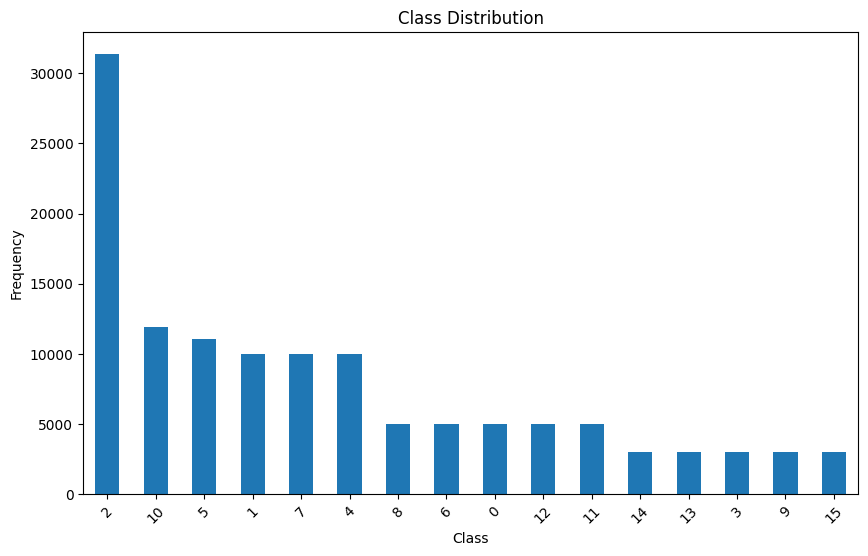

class_label
2     31359
10    11894
5     11075
1     10000
7     10000
4     10000
8      5000
6      5000
0      5000
12     5000
11     5000
14     3000
13     3000
3      3000
9      3000
15     3000
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the 'class' column
plt.figure(figsize=(10,6))
augmented_train_df['class_label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
distribution = augmented_train_df['class_label'].value_counts()
print(distribution)
